In [1]:
!pip install rasterstats

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/egagli@uw.edu/proxy/8787/status,
Dashboard: /user/egagli@uw.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: False
Comm: inproc://10.244.166.14/1673/1,Workers: 4
Dashboard: /user/egagli@uw.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: inproc://10.244.166.14/1673/4,Total threads: 1
Dashboard: /user/egagli@uw.edu/proxy/44649/status,Memory: 8.00 GiB
Nanny: None,


In [4]:
gf = gpd.read_file('https://github.com/scottyhq/snotel/raw/main/snotel-sites.geojson')

In [5]:
snotel_gf = gf[(gf.isActive==True) & (gf.timeseries==True)]
snotel_gf = snotel_gf[(snotel_gf.beginDate<'2015-01-01') & (snotel_gf.endDate>'2022-01-01')]
snotel_gf = snotel_gf[snotel_gf.state!='Alaska']

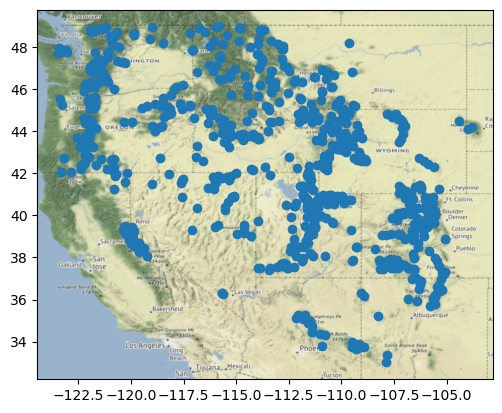

In [6]:
f,ax=plt.subplots()
snotel_gf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [7]:
years = [2015,2016,2017,2018,2019,2020,2021,2022]
#years = [2016,2017,2018,2019,2020,2021,2022]
#years = [2017,2018,2019,2020,2021,2022]
max_swe_years = [f'max_swe_{year}' for year in years]

In [8]:
for i,row in snotel_gf.iterrows():
    snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'{years[0]}-01-01',f'{years[-1]}-12-31')]
    dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
    #print(dates)
    if len(dates)==len(years):
        snotel_gf.loc[i,max_swe_years] = dates.values
    #date_index = []
    #for date in dates.index.values:
    #    date_index.append(f'max_swe_{date}')
    #snotel_gf = snotel_gf.loc[i,iter(date_index)] = dates.loc[2015:2022]

In [9]:
snotel_gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,timeseries,geometry,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,True,...,True,POINT (-120.79192 41.23583),2015-12-28T00:00:00.000000000,2016-02-20T00:00:00.000000000,2017-03-09T00:00:00.000000000,2018-03-27T00:00:00.000000000,2019-03-16T00:00:00.000000000,2020-02-01T00:00:00.000000000,2021-03-15T00:00:00.000000000,2022-03-17T00:00:00.000000000
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,True,...,True,POINT (-112.27118 37.52217),2015-03-05T00:00:00.000000000,2016-02-02T00:00:00.000000000,2017-03-06T00:00:00.000000000,2018-03-19T00:00:00.000000000,2019-03-22T00:00:00.000000000,2020-03-28T00:00:00.000000000,2021-03-17T00:00:00.000000000,2022-03-12T00:00:00.000000000
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,True,...,True,POINT (-111.95902 45.59723),2015-04-17T00:00:00.000000000,2016-04-06T00:00:00.000000000,2017-05-02T00:00:00.000000000,2018-04-17T00:00:00.000000000,2019-05-01T00:00:00.000000000,2020-04-23T00:00:00.000000000,2021-04-27T00:00:00.000000000,2022-06-03T00:00:00.000000000
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,True,...,True,POINT (-121.69847 47.77957),2015-12-28T00:00:00.000000000,2016-04-05T00:00:00.000000000,2017-04-19T00:00:00.000000000,2018-04-18T00:00:00.000000000,2019-03-24T00:00:00.000000000,2020-04-11T00:00:00.000000000,2021-04-17T00:00:00.000000000,2022-04-26T00:00:00.000000000
8,302_OR_SNTL,Aneroid Lake #2,2255.520020,45.213280,-117.192581,Wallowa,Oregon,1980-10-01 00:00:00,2100-01-01,True,...,True,POINT (-117.19258 45.21328),2015-04-09T00:00:00.000000000,2016-05-01T00:00:00.000000000,2017-05-03T00:00:00.000000000,2018-04-22T00:00:00.000000000,2019-04-22T00:00:00.000000000,2020-04-26T00:00:00.000000000,2021-04-16T00:00:00.000000000,2022-05-15T00:00:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,True,...,True,POINT (-110.91773 33.81242),2015-01-18T00:00:00.000000000,2016-02-09T00:00:00.000000000,2017-01-25T00:00:00.000000000,2018-02-20T00:00:00.000000000,2019-02-23T00:00:00.000000000,2020-01-01T00:00:00.000000000,2021-01-30T00:00:00.000000000,2022-01-02T00:00:00.000000000
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,POINT (-111.35685 39.13233),2015-03-04T00:00:00.000000000,2016-03-29T00:00:00.000000000,2017-03-07T00:00:00.000000000,2018-03-23T00:00:00.000000000,2019-03-30T00:00:00.000000000,2020-03-30T00:00:00.000000000,2021-03-24T00:00:00.000000000,2022-03-17T00:00:00.000000000
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,POINT (-112.77495 37.74797),2015-03-04T00:00:00.000000000,2016-03-31T00:00:00.000000000,2017-04-04T00:00:00.000000000,2018-03-05T00:00:00.000000000,2019-03-22T00:00:00.000000000,2020-03-28T00:00:00.000000000,2021-03-27T00:00:00.000000000,2022-03-21T00:00:00.000000000
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,...,True,POINT (-109.81775 43.93225),2015-12-24T00:00:00.000000000,2016-03-29T00:00:00.000000000,2017-03-17T00:00:00.000000000,2018-04-15T00:00:00.000000000,2019-04-16T00:00:00.000000000,2020-04-17T00:00:00.000000000,2021-04-02T00:00:00.000000000,2022-04-29T00:00:00.000000000


In [10]:
for year in years:
    snotel_gf[f'max_swe_{year}'] = pd.to_datetime(snotel_gf[f'max_swe_{year}']).dt.dayofyear

In [11]:
snotel_gf = snotel_gf.to_crs('EPSG:32611')

In [12]:
buffer = 500 # at 1000m with 2015 excluded, medians of medians at 38 days, with 500m 34 days, with 200m 36.25 days, with 2000m 37 days
snotel_gf = gpd.GeoDataFrame(snotel_gf,geometry=snotel_gf.buffer(buffer))

In [13]:
sas_token = "se=2023-02-27T21%3A29Z&sp=racwdl&sv=2018-11-09&sr=c&skoid=b4d39ccb-ca9c-4e9d-a183-5e0f3ba3e609&sktid=f6b6dd5b-f02f-441a-99a0-162ac5060bd2&skt=2023-02-20T21%3A30%3A01Z&ske=2023-02-27T21%3A29%3A00Z&sks=b&skv=2018-11-09&sig=p0mG2aPIjQaBOhBFGGf%2BnGJLZhsarSAn2zoWfB0zxMA%3D"
tile_names = [tile[-5:] for tile in adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token, anon=False).ls('snowmelt/eric/MGRS/')]

In [14]:
stats=['count', 'min', 'max', 'mean', 'median', 'std']

In [15]:
resolution = 80

In [16]:
for i,row in snotel_gf.iterrows():
    if row.mgrs in tile_names:
        print(f'{row.code} in MGRS square {row.mgrs}')
        #f,ax=plt.subplots()
        #aoi = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_allyears_median_40m.tif")
        #aoi.plot(ax=ax)
        
        
        # only keep this line temporary, need to get crs from it. otherwise for plotting purposes, should use aoi from all years
        #aoi = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_2015_median_{resolution}m.tif")
        
        
        #snotel_row_proj = snotel_gf[snotel_gf.index==i].to_crs(aoi.rio.crs)
        #snotel_row_proj.boundary.plot(ax=ax,color='red')
        #ax.set_xlim([snotel_row_proj.total_bounds[0]-2000,snotel_row_proj.total_bounds[2]+2000])
        #ax.set_ylim([snotel_row_proj.total_bounds[1]-2000,snotel_row_proj.total_bounds[3]+2000])
        
        
    
        for year in years:
            #raster = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_{year}_median_40m.tif")
            try:
                raster = rasterio.open(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_{year}_median_{resolution}m.tif")
                #aoi = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_2015_median_{resolution}m.tif")
                snotel_row_proj = snotel_gf[snotel_gf.index==i].to_crs(raster.crs)
                statistics = rasterstats.zonal_stats(snotel_row_proj, raster.read(1), affine=raster.transform, stats=stats, nodata=-32768)
                snotel_gf.loc[i,f'sar_runoff_{year}'] = statistics[0]['median']
                if year == 2022:
                    snotel_gf.loc[i,f'sar_runoff_pixel_count'] = statistics[0]['count']
            except:
                print(f'Error with tile {row.mgrs} for year {year}')

301_CA_SNTL in MGRS square 10TFL
907_UT_SNTL in MGRS square 12SUG
916_MT_SNTL in MGRS square 12TVR
908_WA_SNTL in MGRS square 10TET
302_OR_SNTL in MGRS square 11TML
1000_OR_SNTL in MGRS square 10TEN
303_CO_SNTL in MGRS square 13SDB
1030_CO_SNTL in MGRS square 13TCE
304_OR_SNTL in MGRS square 11TLL
306_ID_SNTL in MGRS square 11TPJ
307_MT_SNTL in MGRS square 12UUU
310_AZ_SNTL in MGRS square 12SXC
Error with tile 12SXC for year 2015
Error with tile 12SXC for year 2016
Error with tile 12SXC for year 2017
Error with tile 12SXC for year 2018
Error with tile 12SXC for year 2019
Error with tile 12SXC for year 2020
Error with tile 12SXC for year 2021
Error with tile 12SXC for year 2022
311_MT_SNTL in MGRS square 11UPP
312_ID_SNTL in MGRS square 11TPK
313_MT_SNTL in MGRS square 12TUS
314_WY_SNTL in MGRS square 12TWP
315_MT_SNTL in MGRS square 12TUR
316_NM_SNTL in MGRS square 13SCA
317_WY_SNTL in MGRS square 13TCF
318_MT_SNTL in MGRS square 12TUQ
319_ID_SNTL in MGRS square 11TNK
321_NV_SNTL in MG

In [17]:
for year in years:
    snotel_gf[f'offset_{year}'] = snotel_gf[f'max_swe_{year}'] - snotel_gf[f'sar_runoff_{year}']

In [18]:
snotel_gf['median_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().median(axis=1)
snotel_gf['mean_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().mean(axis=1)

In [19]:
snotel_gf.sort_values('mean_offset').head(20)
#snotel_gf.sort_values('median_offset').head(20)

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,offset_2015,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
272,472_WY_SNTL,Evening Star,2804.159912,44.652580,-109.784218,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,...,24.0,-8.0,5.0,0.0,3.0,-15.0,-2.0,5.0,5.00,7.7500
80,350_WY_SNTL,Blackwater,2980.944092,44.376671,-109.793327,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,...,3.0,-7.0,3.0,-8.0,25.0,-7.5,7.0,5.0,7.00,8.1875
25,313_MT_SNTL,Barker Lakes,2514.600098,46.097130,-113.130379,Deer Lodge,Montana,1977-08-01 00:00:00,2100-01-01,True,...,-13.0,-4.0,-3.0,-12.0,5.0,-6.0,-11.0,12.0,8.50,8.2500
186,419_WY_SNTL,Cottonwood Creek,2337.815918,42.645901,-110.814819,Lincoln,Wyoming,1980-10-01 00:00:00,2100-01-01,True,...,7.0,-11.0,24.5,11.5,-2.0,5.0,4.5,1.0,6.00,8.3125
83,353_WY_SNTL,Blind Bull Sum,2636.520020,42.964001,-110.609734,Sublette,Wyoming,1978-10-01 00:00:00,2100-01-01,True,...,12.0,13.0,1.0,-7.0,-31.0,1.0,-2.0,-2.0,4.50,8.6250
118,376_WA_SNTL,Bunchgrass Mdw,1524.000000,48.686878,-117.176331,Pend Oreille,Washington,1979-10-01 00:00:00,2100-01-01,True,...,15.0,0.0,-7.0,-7.0,-4.0,-26.0,-22.0,-4.0,7.00,10.6250
286,481_UT_SNTL,Five Points Lake,3335.426514,40.717850,-110.467209,Duchesne,Utah,1980-08-14 00:00:00,2100-01-01,True,...,-20.0,-2.0,2.5,21.0,8.0,-9.5,21.5,1.0,8.75,10.6875
427,1115_UT_SNTL,Klondike Narrows,2209.800049,41.967690,-111.597130,Cache,Utah,2009-10-01 00:00:00,2100-01-01,True,...,-11.0,-7.0,3.0,-2.0,-13.0,-16.0,-8.0,-26.0,9.50,10.7500
825,1013_UT_SNTL,Temple Fork,2257.348877,41.792999,-111.546051,Cache,Utah,2001-11-05 00:00:00,2100-01-01,True,...,-9.0,-7.0,-3.0,-52.0,-3.0,3.0,-5.0,5.0,5.00,10.8750
8,302_OR_SNTL,Aneroid Lake #2,2255.520020,45.213280,-117.192581,Wallowa,Oregon,1980-10-01 00:00:00,2100-01-01,True,...,20.0,-16.5,9.0,-3.0,-4.0,-11.0,-21.0,-3.0,10.00,10.9375


Text(0.5, 0, 'Offset [Days]')

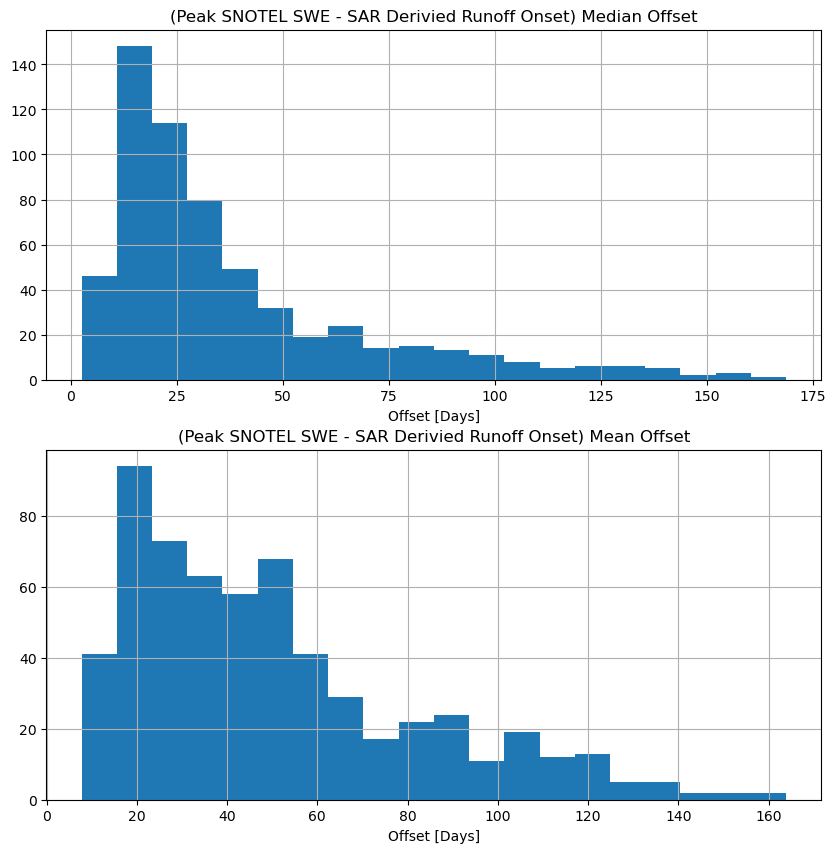

In [20]:
f,ax=plt.subplots(2,1,figsize=(10,10))
snotel_gf['median_offset'].hist(bins=20,ax=ax[0])
snotel_gf['mean_offset'].hist(bins=20,ax=ax[1])
ax[0].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Median Offset')
ax[1].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Mean Offset')
ax[0].set_xlabel('Offset [Days]')
ax[1].set_xlabel('Offset [Days]')

In [21]:
snotel_gf['median_offset'].median()

27.0

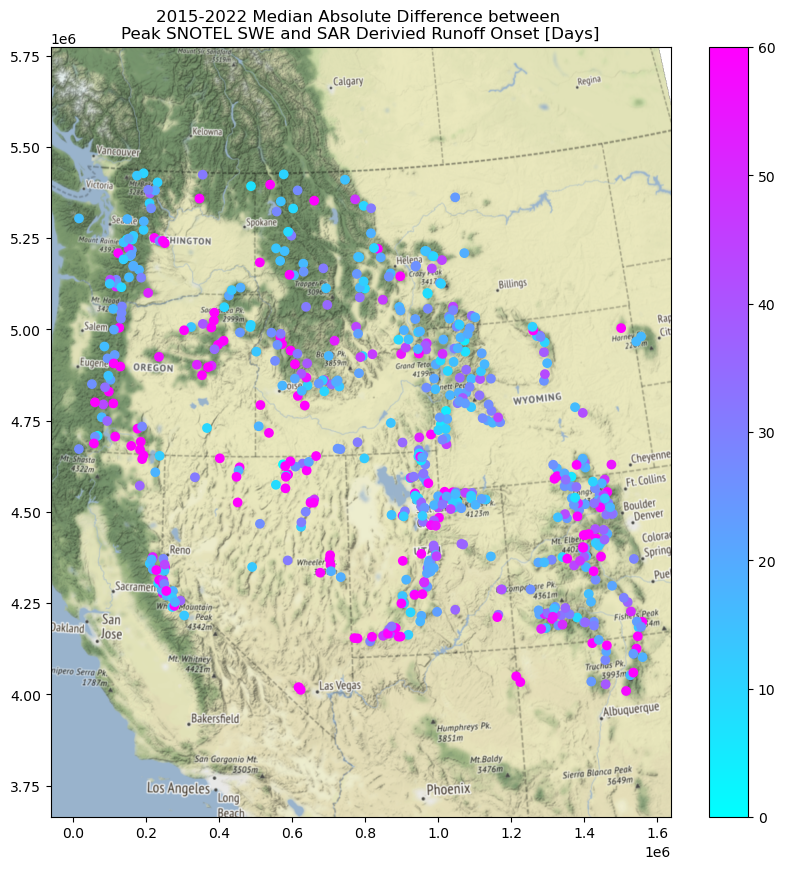

In [28]:
f,ax=plt.subplots(figsize=(10,10))
snotel_gf_projected = gpd.GeoDataFrame(snotel_gf,geometry=gf.geometry).to_crs('EPSG:32611')
snotel_gf_projected.plot(column='median_offset',ax=ax,legend=True,cmap='cool',vmin=0,vmax=60)
ax.axis('equal')
ax.set_title('2015-2022 Median Absolute Difference between \nPeak SNOTEL SWE and SAR Derivied Runoff Onset [Days]')
ctx.add_basemap(ax=ax, crs=snotel_gf_projected.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [23]:
tooltip_list = ['code','name','elevation_m']
for year in years:
    tooltip_list.append(f'offset_{year}')                
tooltip_list.extend(['median_offset','mean_offset','sar_runoff_pixel_count'])

In [29]:
snotel_gf_projected.drop(['beginDate','endDate','isActive','timeseries'],axis=1).explore(column='median_offset',
                                                                 cmap='cool',tooltip=tooltip_list,vmin=0,vmax=60)

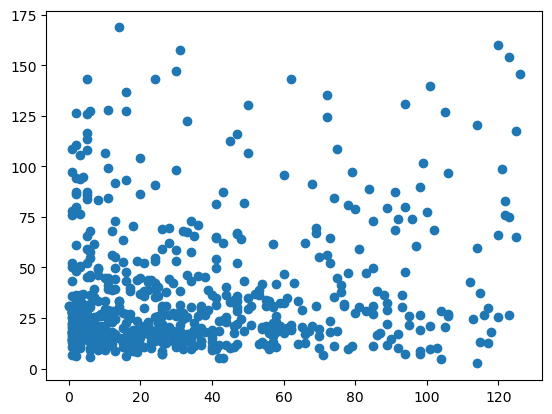

In [25]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['sar_runoff_pixel_count'],snotel_gf_projected['median_offset'])
#ax.set_xlim([0,10])

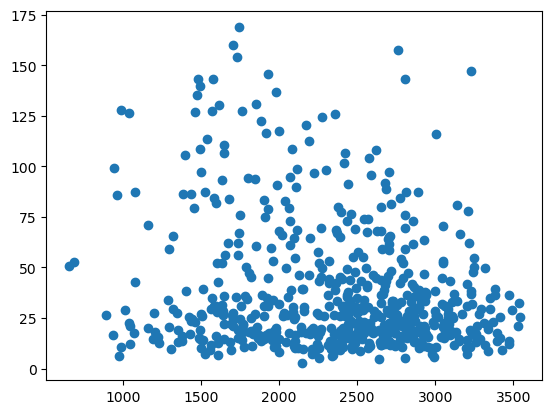

In [26]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['elevation_m'],snotel_gf_projected['median_offset'])

In [27]:
snotel_gf_projected.corr()

,elevation_m,latitude,longitude,isActive,timeseries,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,...,offset_2015,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
elevation_m,1.000000,-0.677969,0.795036,NaN,NaN,-0.481028,0.079633,0.181171,0.110220,0.343624,...,-0.420013,0.056166,0.115094,0.087662,0.049687,0.117360,0.004276,0.049274,-0.207378,-0.329487
latitude,-0.677969,1.000000,-0.480536,NaN,NaN,0.154086,0.202973,0.330365,-0.251299,-0.061591,...,0.114423,0.183521,0.171778,-0.111606,0.080559,0.122644,-0.172340,0.103309,-0.157842,-0.146429
longitude,0.795036,-0.480536,1.000000,NaN,NaN,-0.646820,0.108228,0.015810,0.143194,0.247550,...,-0.589974,0.032512,-0.001132,0.091498,-0.061160,0.026279,-0.171163,-0.022940,-0.139037,-0.325190
isActive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timeseries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_swe_2015,-0.481028,0.154086,-0.646820,NaN,NaN,1.000000,-0.131324,-0.103294,-0.007766,-0.235370,...,0.954923,-0.132892,-0.104630,0.058700,-0.048782,-0.172582,0.091391,0.013231,0.286339,0.527196
max_swe_2016,0.079633,0.202973,0.108228,NaN,NaN,-0.131324,1.000000,0.305317,-0.180962,0.147508,...,-0.241335,0.726144,0.222912,-0.052042,0.082835,0.315945,-0.067006,0.105130,-0.353530,-0.361499
max_swe_2017,0.181171,0.330365,0.015810,NaN,NaN,-0.103294,0.305317,1.000000,-0.172029,0.337188,...,-0.109119,0.290851,0.679690,-0.020211,0.281755,0.318234,-0.006413,0.209502,-0.474267,-0.479958
max_swe_2018,0.110220,-0.251299,0.143194,NaN,NaN,-0.007766,-0.180962,-0.172029,1.000000,0.101965,...,0.050380,-0.097982,-0.056066,0.836259,-0.023883,-0.195687,0.088551,0.017240,0.197906,0.264292
max_swe_2019,0.343624,-0.061591,0.247550,NaN,NaN,-0.235370,0.147508,0.337188,0.101965,1.000000,...,-0.278649,0.337549,0.428196,-0.024515,0.382460,0.334662,0.010256,0.210253,-0.506698,-0.599074
